In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [86]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting, zonal_error_plotting
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb

In [ ]:
plt.rcParams['figure.figsize'] = [40, 15]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 120 

In [5]:
num_workers = 2
test_set = "era5"
DATA_DIR = "./data"

overrides = [f'datamodule.num_workers={num_workers}',
             f'datamodule.partition={[0.85, 0.15, test_set]}',
             'datamodule.eval_batch_size=30',
             'verbose=False',
             f'datamodule.data_dir={DATA_DIR}'
            ]

In [6]:
cur_run_id = None
def get_model_and_dm_from_run_id(run_id):
    global cur_run_id
    cur_run_id = run_id
    values = reload_checkpoint_from_wandb(run_id=run_id, project='AIBEDO', override_key_value=overrides, try_local_recovery=False)
    return  values['model'], values['datamodule'], values['config']

In [7]:
def get_predictions_xarray(run_id, split='predict', return_normalized_outputs=False, variables='all'):
    model, dm, cfg = get_model_and_dm_from_run_id(run_id)
    print('physics_loss_weights:', cfg.model.physics_loss_weights)
    dm.setup(stage=split)
    dataloader = dm.val_dataloader() if 'val' in split else dm.predict_dataloader()
    predictions_xarray = dm.get_predictions_xarray(model, dataloader=dataloader, return_normalized_outputs=return_normalized_outputs, variables=variables)
    del model, dm, cfg
    return predictions_xarray

# Reload and predict with some models:
#### Baseline MLP, without any constraints

In [8]:
rid_baseline = "mkq91941"
ds_mlp = get_predictions_xarray(rid_baseline, split='predict')

physics_loss_weights: [0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
len(np.unique(ds_mlp.latitude.values))

10305

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


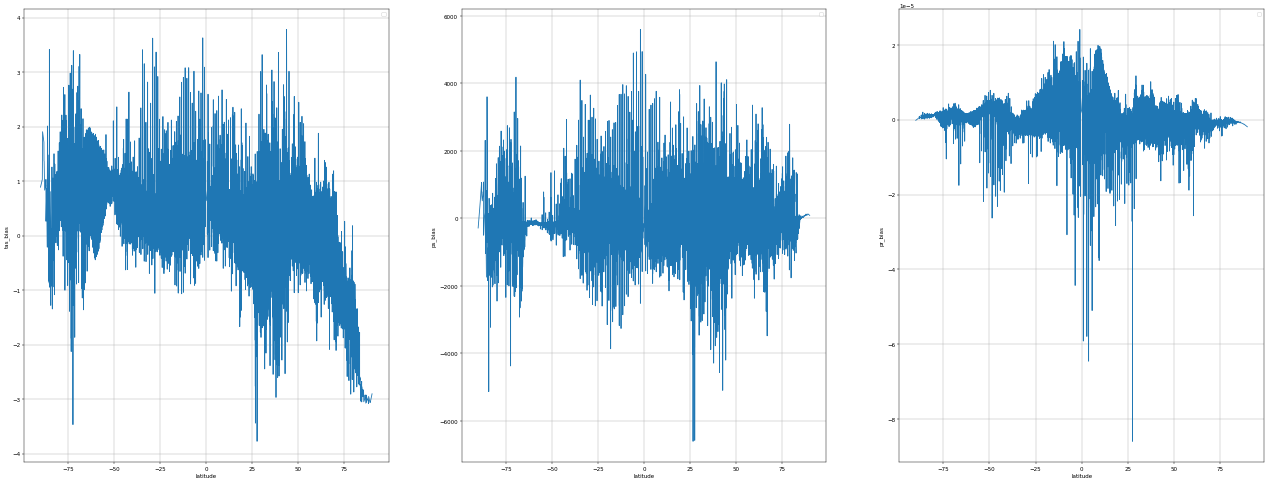

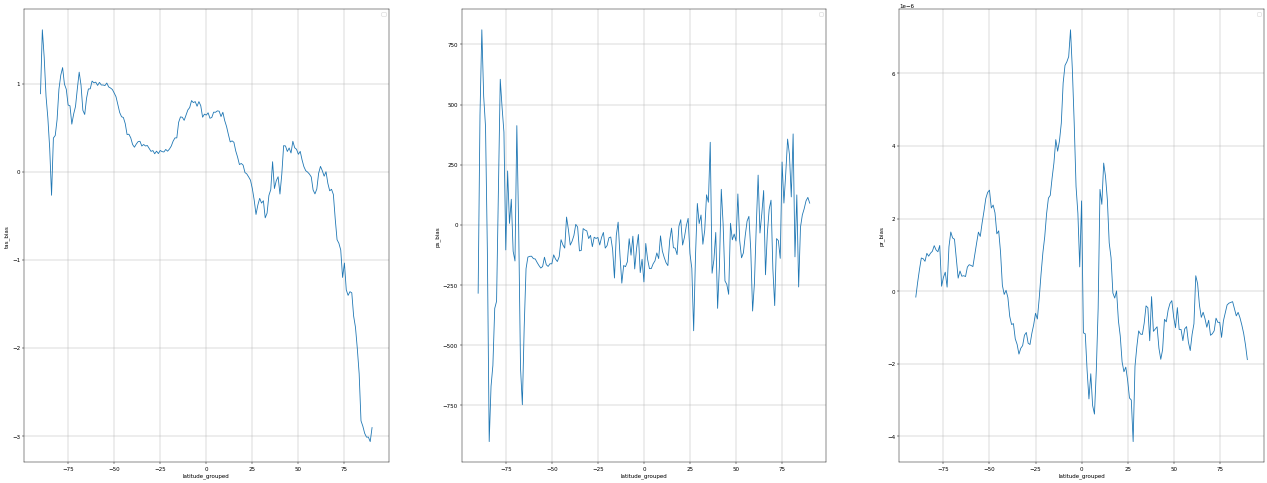

In [67]:
plt.rcParams['figure.dpi'] = 40
_ = zonal_error_plotting(ds_mlp, latitude_dim='latitude')
_ = zonal_error_plotting(ds_mlp, latitude_dim='latitude_grouped')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


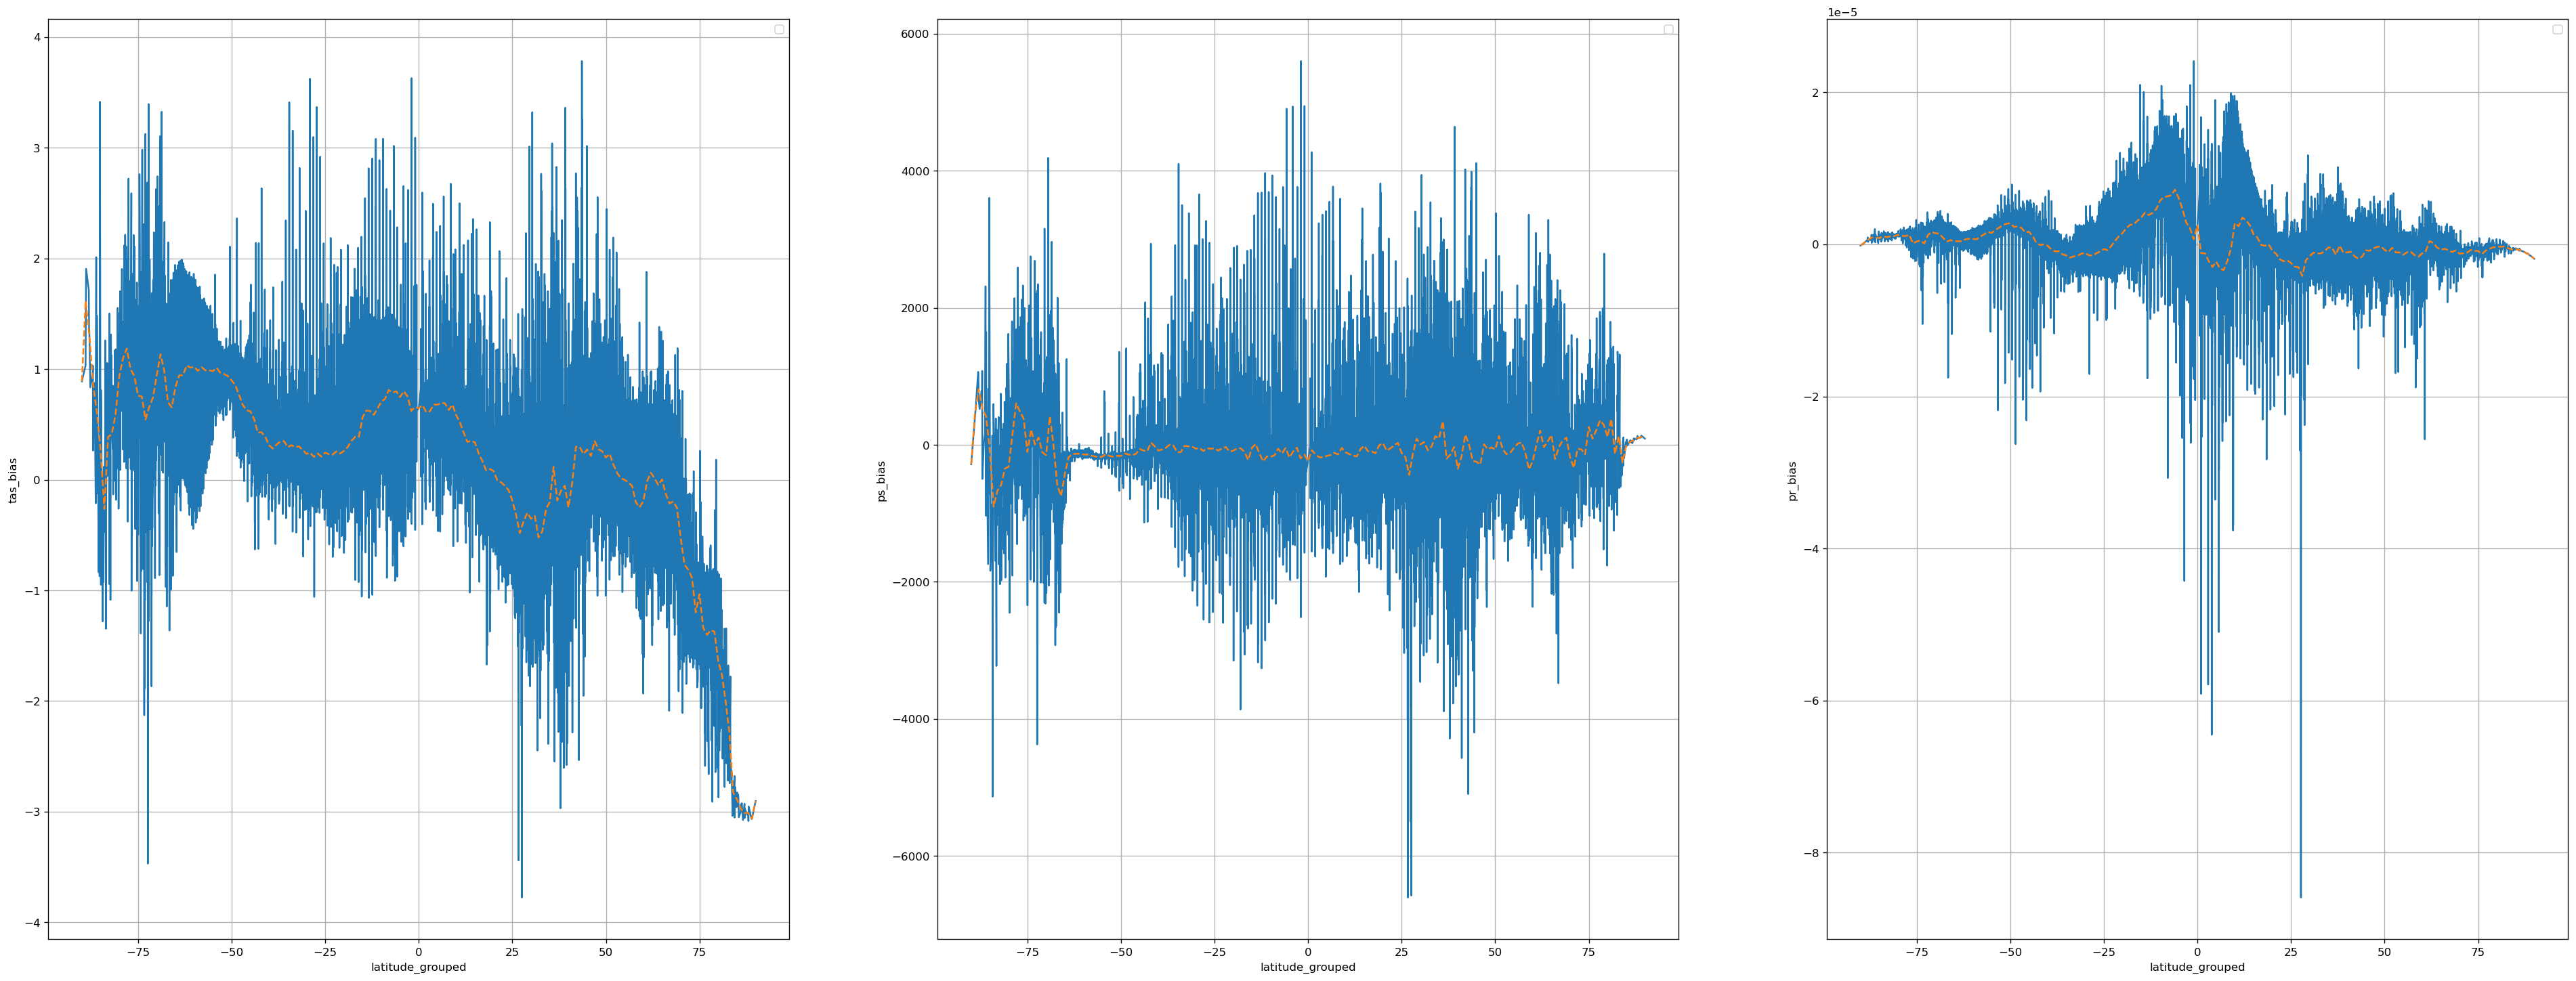

In [63]:
_ = zonal_error_plotting(ds_mlp)

#### MLP with non-negative preds (1)

In [70]:
rid_all= "34q3echu"
ds_nn1 = get_predictions_xarray(rid_all, split='predict')

physics_loss_weights: [0, 0, 1000, 1.0, 0.0001]


#### MLP with non-negative preds (no other constraints)

In [71]:
rid_c5_only = "gvm2lblj"  # non-neg during training
ds_nn2 = get_predictions_xarray(rid_c5_only, split='predict')

physics_loss_weights: [0.0, 0.0, 0, 1.0, 0.0]


In [73]:
for var in ['pr', 'tas', 'ps']:
    for ds in [ds_mlp, ds_nn1, ds_nn2]:
        ds[f'{var}_mae'] = np.abs(ds[f'{var}_preds'] - ds[f'{var}_targets'])
        ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']

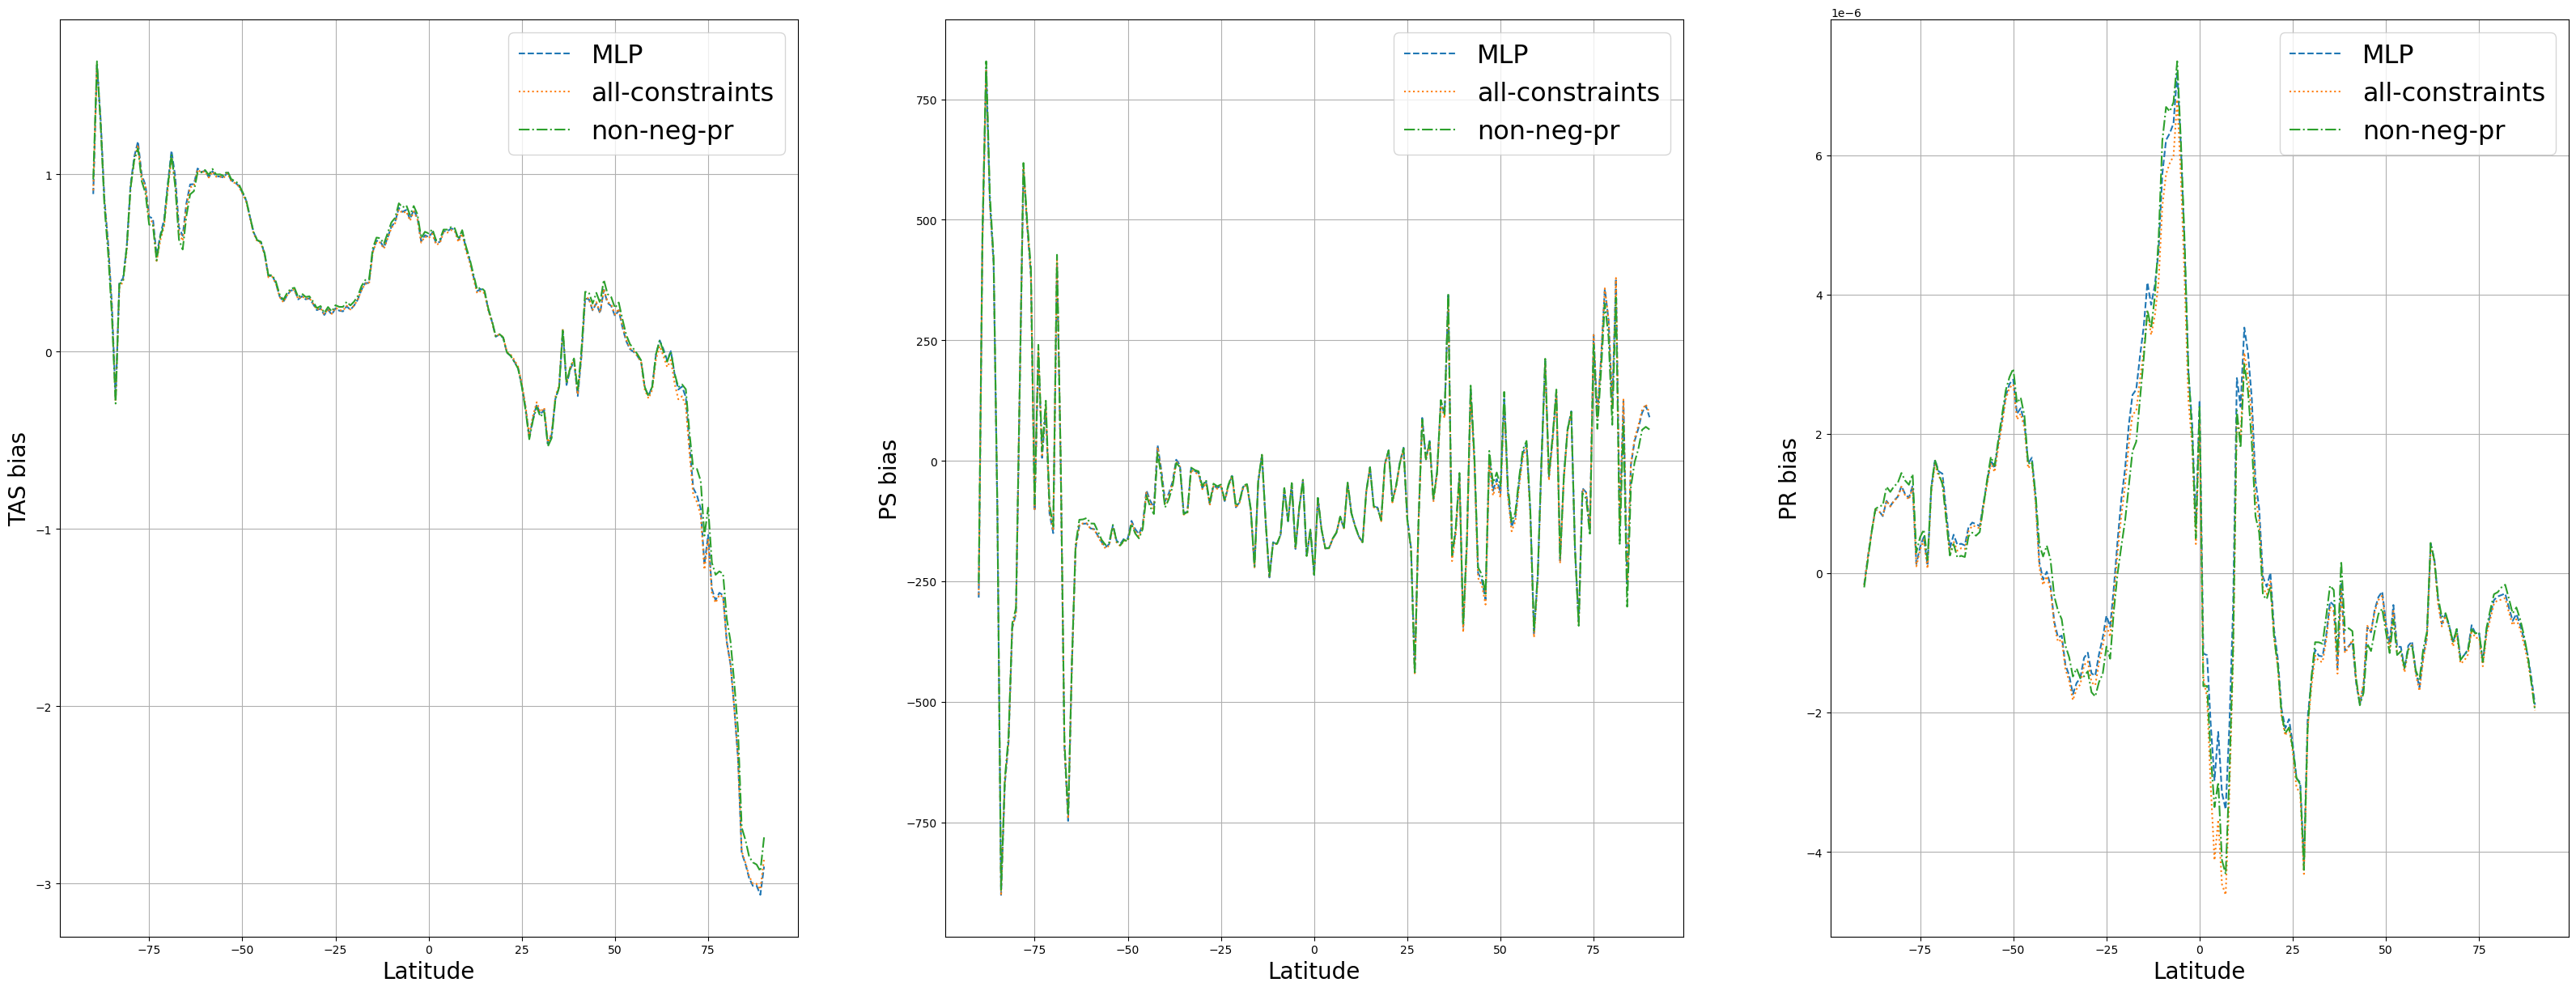

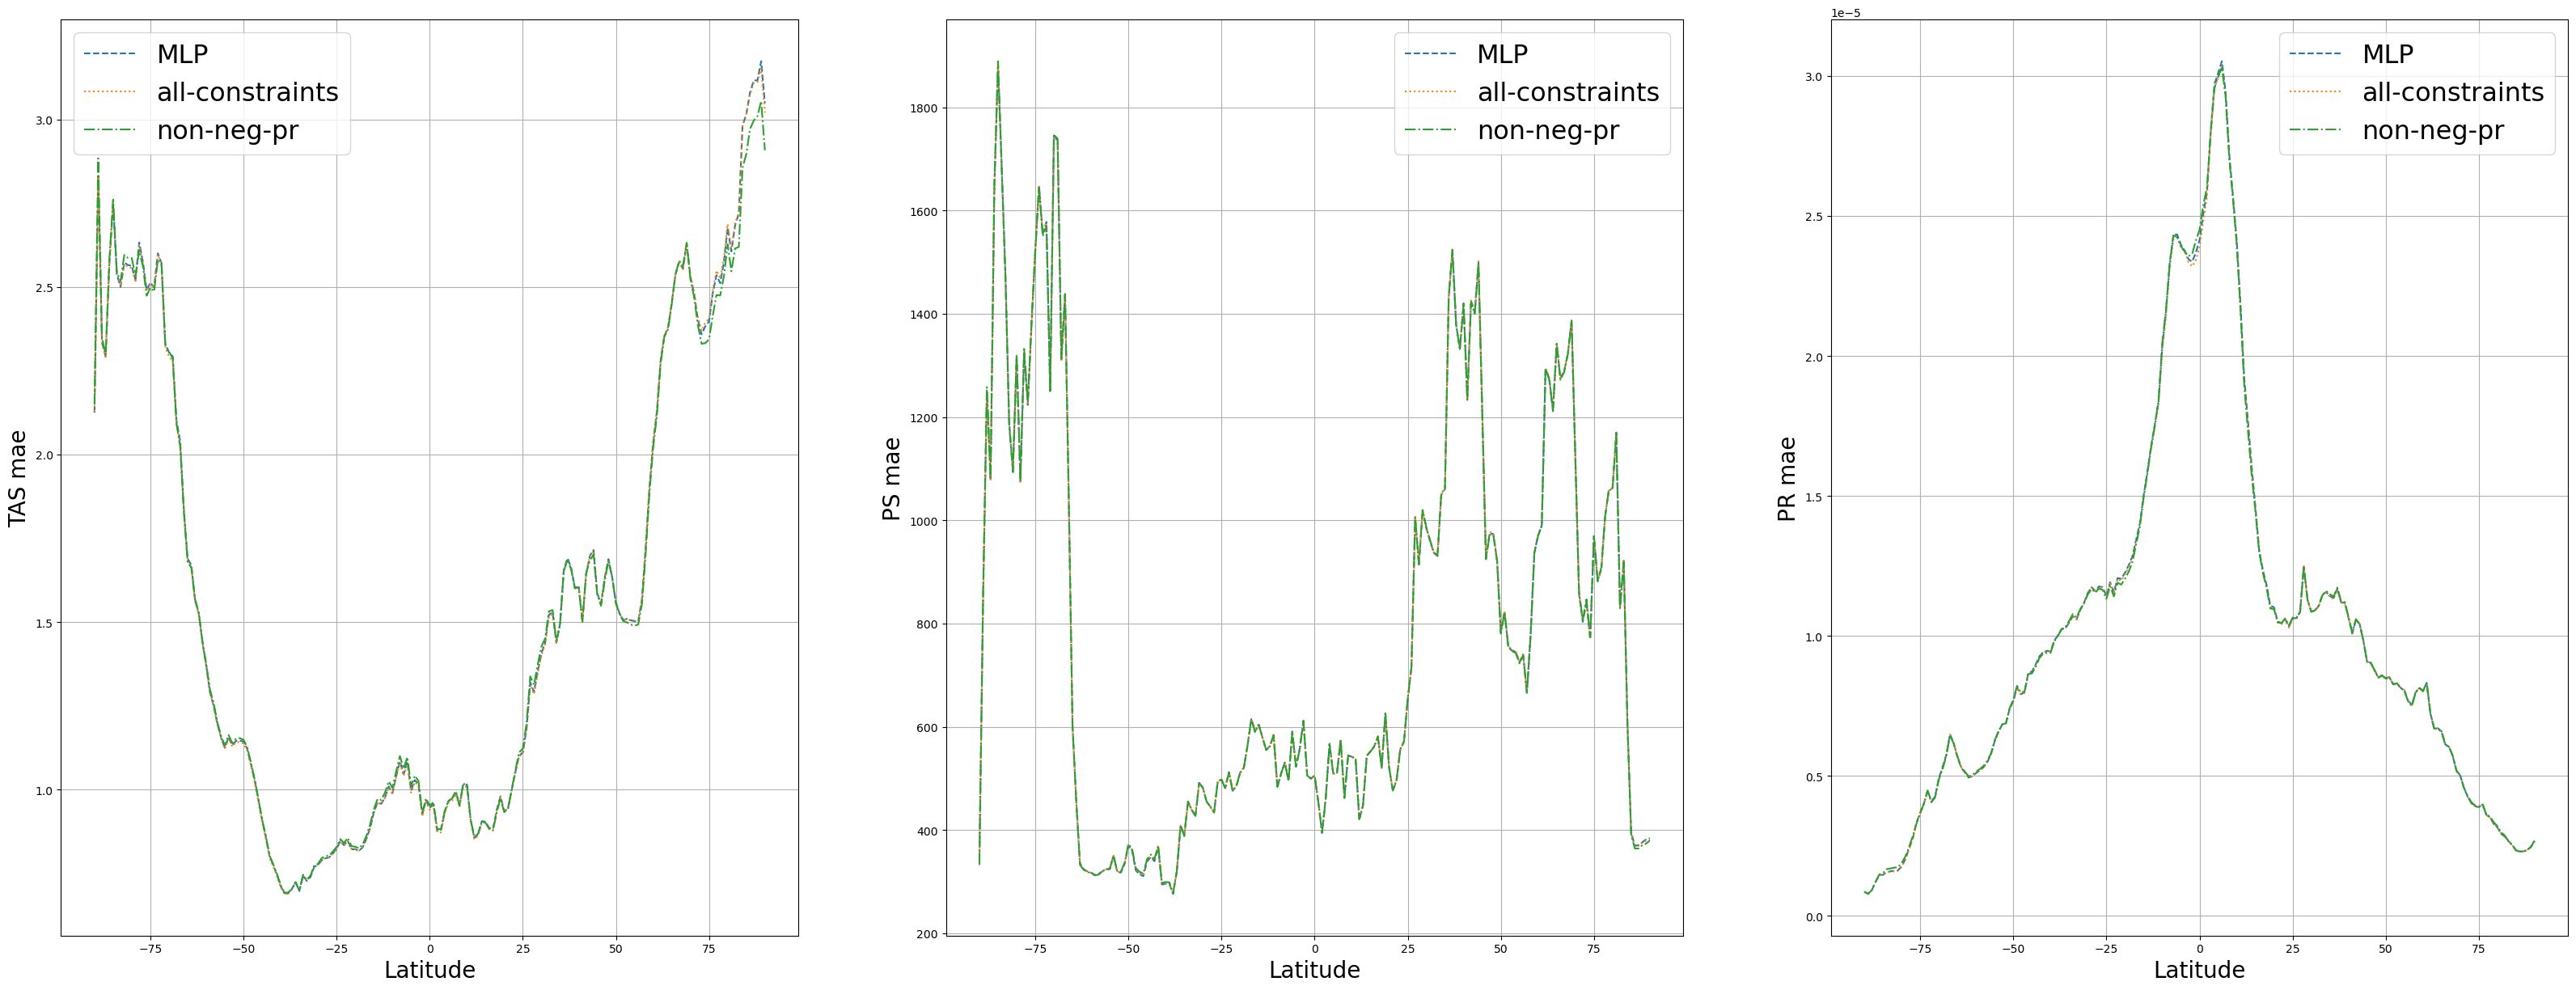

In [85]:
plt.rcParams['figure.dpi'] = 100 
_ = zonal_error_plotting([ds_mlp, ds_nn1, ds_nn2], labels=['MLP', 'all-constraints', 'non-neg-pr'], latitude_dim='latitude_grouped')
_ = zonal_error_plotting([ds_mlp, ds_nn1, ds_nn2], labels=['MLP', 'all-constraints', 'non-neg-pr'], latitude_dim='latitude_grouped', error_to_plot='mae')